In [1]:
import math
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np

In [2]:
#load data
hiparray = np.loadtxt(open("hip1000.txt"), delimiter=",")
hiparray = hiparray[:10]
hipT = np.transpose(hiparray)
hipgene = np.array(hipT)
print(len(hipgene), len(hipgene[0])) #879 datapoints, with 10 features. (geneXsample)

879 10


In [3]:
#parse data test_mean.txt
lines = []
k1, k2, k3 = [],[],[]
with open('test_mean.txt') as f:
    lines = f.readlines()
for line in lines:
    line = line.strip()
    line = line.split()
    k1.append(float(line[0]))
    k2.append(float(line[1]))
    k3.append(float(line[2]))
init_mu = np.array([k1[:10],k2[:10],k3[:10]])
print(np.shape(init_mu))

(3, 10)


In [4]:
#initialize covariance, cluster probability
init_cov = []
for i in range(3):
    init_cov.append(np.identity(10))
init_pc = np.array([0.3,0.3,0.4])
print(np.shape(init_cov))
print(np.shape(init_pc))

(3, 10, 10)
(3,)


In [5]:
#multivariate gaussian distribution PDF 
def GaussianPDF(x, mu, sigma):
    dim = np.shape(sigma)[0]
    sigma = sigma+np.eye(dim)*0.000001 #accomodate overflow
    covDet = np.linalg.det(2*np.pi*(sigma))
    covInv = np.linalg.inv(sigma)
    diff = x-mu
    pdf = (1/(covDet**0.5))*np.exp(-0.5*diff.T.dot(covInv).dot(diff))
    return pdf

In [6]:
#compute the loglikelihood 
def logll(data, pc, mu, sigma):
    logl = []
    for x in range(len(data)):
        tmp = 0
        for y in range(len(pc)):
            tmp += GaussianPDF(data[x], mu[y], sigma[y])*pc[y]
        logl.append(np.log(tmp))
    return sum(logl)
            

In [7]:
#EM algorithm
def EM(data, pc, mu, sigma):
    l, dim = np.shape(data)
    logs = []
    newlog = -1
    prevlog = 0
    hiddenM = np.array([np.zeros(len(pc)) for i in range(l)])
    
    while abs(prevlog-newlog) > 0.001:
        prevlog = newlog
        # e step
        for x in range(l):
            pdfList = []
            for y in range(len(pc)):
                tmp = GaussianPDF(hipgene[x], mu[y], sigma[y])*pc[y]
                pdfList.append(tmp)
            for y in range(len(pc)):
                hiddenM[x][y] = pdfList[y]/np.sum(pdfList)
        # m step
        for i in range(len(pc)):
            xsum = np.sum(hiddenM[:,i])
            pc[i] = xsum/l
            #update mean matrix
            mean = np.sum([hiddenM[n][i]*data[n] for n in range(l)], axis=0) /xsum
            mu[i] = mean
            #update covariance matrix
            xdiff = data-mean
            sigman = np.sum([xdiff[n].reshape((dim,1)).dot(xdiff[n].reshape(1,dim))*hiddenM[n][i] for n in range(l)], axis = 0)
            sigma[i] = sigman/xsum
        #After EM step, calculate loglikelihood.
        newlog = logll(data, pc, mu, sigma)
        logs.append(newlog)
    
    return logs


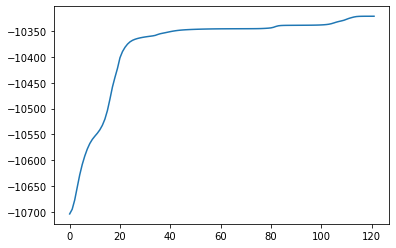

-10321.376847744641


In [8]:
q1res = EM(hipgene, init_pc, init_mu, init_cov)
plt.plot(q1res)
plt.show()
print(q1res[-1])

In [9]:
import random
#random initialization
def ranMix(r):
    s = 0
    res = []
    for i in range(r):
        res.append(random.uniform(0.00001,1-s))
        s+=res[-1]
    return res

In [10]:
#using a randomly initialized mix probability of each cluster
q3res = []
for i in range(10):
    rmix = ranMix(3)
    print(rmix)
    tmp = EM(hipgene, rmix, init_mu, init_cov)
    q3res.append(tmp[-1])
print(q3res)


[0.7671585138149606, 0.19788602361066962, 0.016299521131379117]
[0.7586048598724734, 0.12995350591176652, 0.06034813262978478]
[0.7477828172499265, 0.21862203481574802, 0.03131230418237497]
[0.8803648605394473, 0.02085460342711632, 0.08085052526094122]
[0.5417984996430719, 0.19628082819770615, 0.09218090656966829]
[0.5903434000900959, 0.15578135681000116, 0.2398312647539279]
[0.11432711634221598, 0.1283233235749653, 0.5577440604744421]
[0.3958060543155202, 0.06364229848272876, 0.02751530000158708]
[0.8950231306946236, 0.07072197055624416, 0.013258706001783869]
[0.6208367842605931, 0.3456188884787383, 0.005003598863042083]
[-10321.376846833844, -10321.376614376104, -10321.376543140579, -10321.37655376139, -10321.376704934366, -10321.376690456687, -10321.376799275897, -10321.37664469465, -10321.376576452776, -10320.668270667506]


In [11]:
def ranMean(r):
    res = []
    for i in range(r):
        tmp = []
        for z in range(10):
            tmp.append(random.uniform(-2,2))
        res.append(tmp)
    return np.array(res)

In [12]:
# loglikelihood for cluster of size 3 to 10
like = []
for i in range(3,11):
    init_cov = []
    for x in range(i):
        init_cov.append(np.identity(10))
    tmp = EM(hipgene, ranMix(i), ranMean(i), init_cov)
    like.append(tmp[-1])
print(like)

[-10346.953856881595, -10229.317601033668, -10152.176857668124, -10118.150697657933, -9999.70641416629, -9919.078568575746, -9714.220730955753, -9708.951189893403]
